<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

## Task 1: Project Overview and Import Libraries

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


## Task 2: Load and Preprocess the Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

In [3]:
type(x_train)

numpy.ndarray

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

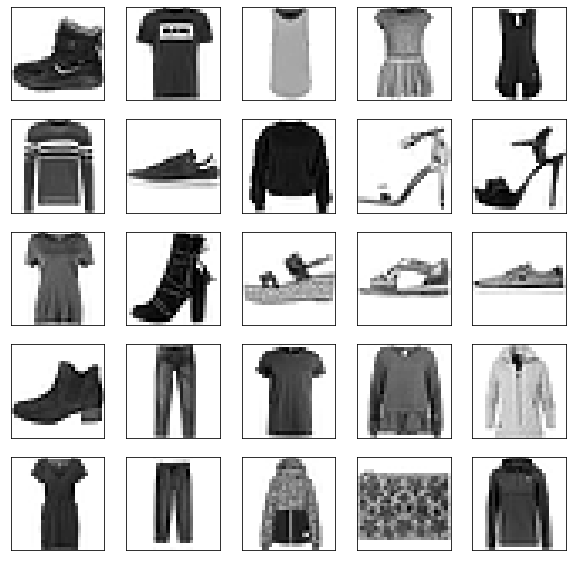

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
# plt.show()

## Task 3: Create Batches of Training Data

In [6]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset

<ShuffleDataset shapes: (28, 28), types: tf.float32>

In [9]:
# drop rem = True, so that tf ignores the last batch and we are able to get a full shape propagation
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
dataset

<PrefetchDataset shapes: (32, 28, 28), types: tf.float32>

## Task 4: Build the Generator Network for DCGAN

![GAN](DCGAN.png)

**Generator** is an upsampling network with fractionally-strided convolutions 

[Fractionally strided convolutions, sometimes referred to as deconvolutions, transpose images, typically from a minimized format to a larger one. Imagine an image that has been reduced to a 2x2 pixel format. To transpose the image up to a larger format, a fractionally strided convolution reconstructs the image's spatial resolution, then performs the convolution]

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [10]:
num_features = 300 #choose based on the computational power you have
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 *128, input_shape=[num_features]),
    keras.layers.Reshape([7,7,128]),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh')
])
'''stride = 2,2
    activation = selu; prev recommendation is relu, 
    but emperical obeservation says selu greatly improves the convergence speed,
    selu + batch_norm : avoids gradient explosion - stabilizes DCGAn training
    '''

'stride = 2,2\n    activation = selu; prev recommendation is relu, \n    but emperical obeservation says selu greatly improves the convergence speed,\n    selu + batch_norm : avoids gradient explosion - stabilizes DCGAn training\n    '

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              1887872   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 2,095,105
Trainable params: 2,094,721
Non-trainable params: 384
____________________________________________

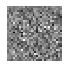

In [12]:
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise, training=False)
plot_utils.show(generated_image, 1)

In [13]:
# try with some other noise as well: from some other distribution

## Task 5: Build the Discriminator Network for DCGAN

In [14]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [16]:
# looking at the output from the untrained discriminator
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50339574]], shape=(1, 1), dtype=float32)


## Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [17]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False # because first we will just train our generator

In [18]:
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [19]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         2095105   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 2,307,970
Trainable params: 2,094,721
Non-trainable params: 213,249
_________________________________________________________________


## Task 7: Define Training Procedure

In [20]:
seed = tf.random.normal(shape=[batch_size, num_features])

In [32]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers # because the generator and discriminator are the layers of the gan model
    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch+1, epochs))
        for X_batch in dataset:
            # first training the G a bit, to gen mini-batch of fake images
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            # concatenate the list of fake images and real images
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            # labelling the fake images with 0, real images with 1
            class_labels_1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
            discriminator.trainiable = True
            discriminator.train_on_batch(X_fake_and_real, class_labels_1)
            class_labels_2 = tf.constant([[1.]]*batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, class_labels_2)
            
            
        # Creating a gif of the images :
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [25]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Task 8: Train DCGAN

In [26]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1)*2. -1.

In [28]:
x_train_dcgan.shape

(60000, 28, 28, 1)

In [30]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

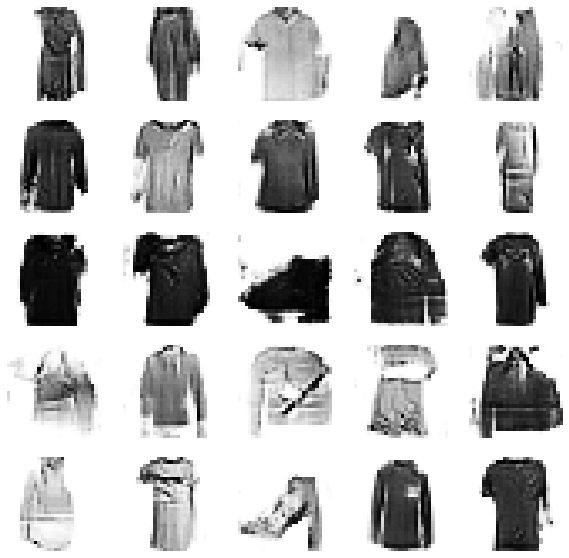

CPU times: user 6min 13s, sys: 9.91 s, total: 6min 23s
Wall time: 9min 40s


In [33]:
%%time
# train with more epochs and change the G and D models
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

## Task 9: Generate Synthetic Images with DCGAN

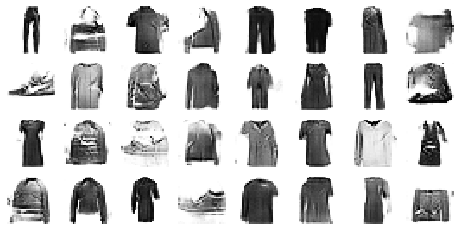

In [35]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
plot_utils.show(generated_images, 8)

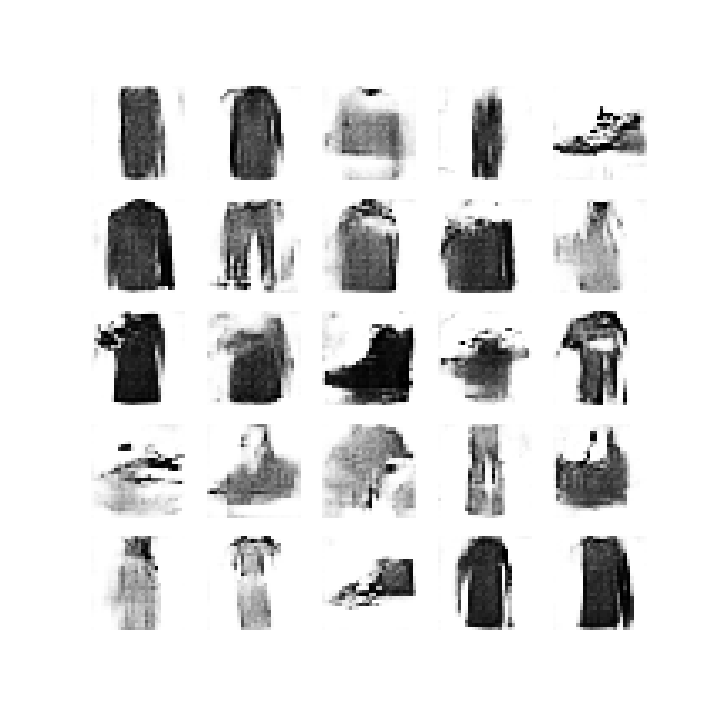

In [36]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)